In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%load_ext Cython

# Testing get patches.so

Input:

NxCxHxW - stack of images

h,w - patch size

Output:

NxHxWxhxwxC - patches

In [2]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef get_patches3(np.ndarray[np.float64_t,ndim=4] D, np.ndarray[np.float_t,ndim=2] xk, int h=3, int w=3, stride=1):

    cdef int N = D.shape[0]
    cdef int C = D.shape[1]
    cdef int H = D.shape[2]
    cdef int W = D.shape[3]
    cdef int nKps = H*W
    cdef int n,c,i,j,ii,jj
    cdef int F = xk.shape[0]
    cdef f


    cdef int h_pad = int((H * (stride - 1) - stride + h) / 2)
    cdef int w_pad = int((W * (stride - 1) - stride + w) / 2)

    cdef int h_ = int((h - 1) / 2)
    cdef int w_ = int((w - 1) / 2)
    

    cdef np.ndarray[np.float64_t,ndim=6] patches = np.zeros((N,H,W,h,w,C))
    cdef np.ndarray[np.float64_t,ndim=4] D_padded = np.pad(D, ((0, 0), (0,0), (h_pad, h_pad), (w_pad, w_pad)), 'edge')
    
    for f in range(F):
        n, c, i, j = xk[f].astype(int)
        
        ii = i+h_pad
        jj = j+w_pad
        patches[n,i,j,:,:,c] = D_padded[n, c, ii - h_:ii + h_ + 1, jj - w_:jj + w_ + 1]

    return patches

In [3]:
H,W = 100,200

(3, 100, 200)

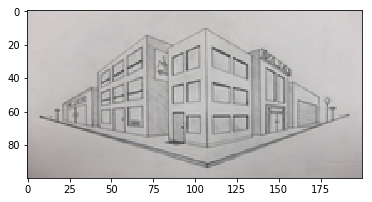

In [4]:
im1 = Image.open('img/2ptpersp.jpg')
im1 = im1.resize((W,H),Image.ANTIALIAS)
im1 = np.array(im1)
plt.imshow(im1)
im1 = np.moveaxis(im1,2,0)
im1.shape

(3, 100, 200)

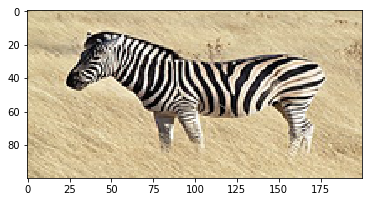

In [5]:
im2 = Image.open('img/zebra.jpg')
im2 = im2.resize((W,H),Image.ANTIALIAS)
im2 = np.array(im2)
plt.imshow(im2)
im2 = np.moveaxis(im2,2,0)
im2.shape

(3, 100, 200)

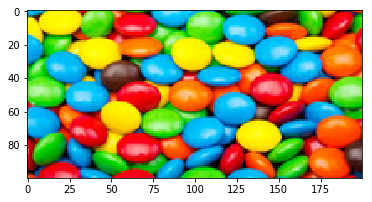

In [6]:
im3 = Image.open('img/candies.jpg')
im3 = im3.resize((W,H),Image.ANTIALIAS)
im3 = np.array(im3)
plt.imshow(im3)
im3 = np.moveaxis(im3,2,0)
im3.shape


## Image stack

In [7]:
im = np.stack((im1,im2,im3)).astype(np.float64)

## Image stack - keypoints:

In [8]:
xk = np.indices(im.shape).reshape((4,-1)).astype(np.float64)
n,c,i,j = xk
xk.shape

(4, 180000)

## Get patches (h x w)

In [9]:
h=11
w=11
nBins=10
patches = get_patches3(im, xk.T,h,w)

## Verification

In [10]:
def plot(n,patches):
    N,H,W,h,w,C = patches.shape
    h_range = np.arange(0,H,h).astype(int)
    w_range = np.arange(0,W,w).astype(int)

    plt.subplots(len(h_range),len(w_range))
    count=1

    for i in h_range:
        for j in w_range: 
            plt.subplot(len(h_range),len(w_range),count)
            plt.imshow(patches[n,i,j,:,:,:].astype(np.uint8))
            plt.axis('off')
            count+=1
    plt.show()

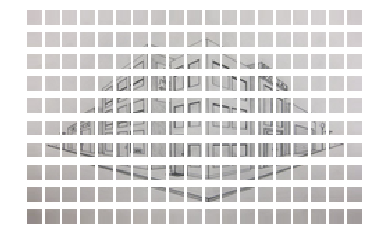

In [11]:
plot(0,patches)

(array([ 390540.,  421114.,  417333.,  634076., 1135284., 1825576.,
        2703332., 3695501., 3698490.]),
 array([ 64.        ,  80.66666667,  97.33333333, 114.        ,
        130.66666667, 147.33333333, 164.        , 180.66666667,
        197.33333333, 214.        ]),
 <a list of 9 Patch objects>)

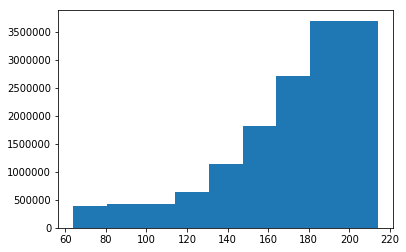

In [12]:
plt.hist(patches.flatten(),bins = np.linspace(patches[0].min(),patches[0].max(),nBins))

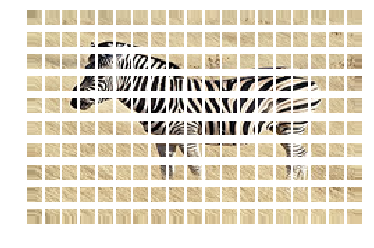

In [13]:
plot(1,patches)

(array([2846079.,  688164.,  643834.,  735423., 1290991., 3101746.,
        5912043., 4358794., 2202926.]),
 array([  0.        ,  28.33333333,  56.66666667,  85.        ,
        113.33333333, 141.66666667, 170.        , 198.33333333,
        226.66666667, 255.        ]),
 <a list of 9 Patch objects>)

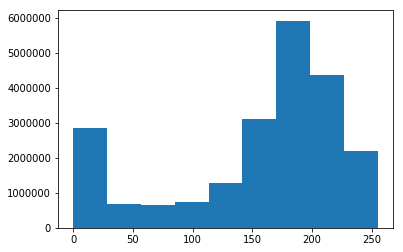

In [14]:
plt.hist(patches.flatten(),bins = np.linspace(patches[1].min(),patches[1].max(),nBins))

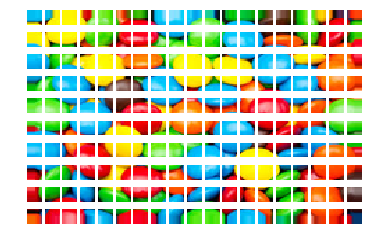

In [15]:
plot(2,patches)

(array([2846079.,  688164.,  643834.,  735423., 1290991., 3101746.,
        5912043., 4358794., 2202926.]),
 array([  0.        ,  28.33333333,  56.66666667,  85.        ,
        113.33333333, 141.66666667, 170.        , 198.33333333,
        226.66666667, 255.        ]),
 <a list of 9 Patch objects>)

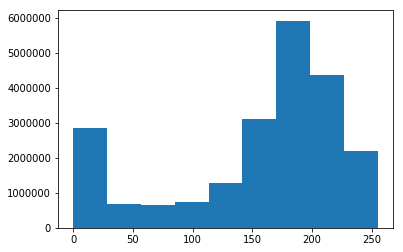

In [16]:
plt.hist(patches.flatten(),bins = np.linspace(patches[1].min(),patches[1].max(),nBins))

# Build Histogram

In [17]:
def build_hist(patches,nBins=10,pmin=0.,pmax=255.):

    bins = np.linspace(pmin,pmax,nBins)
    inds = np.digitize(patches,bins)
    
    N,H,W,C,h,w = inds.shape
    
    inds = np.reshape(inds,(N,H,W,C,h*w))   
    
    hists = np.zeros((N,H,W,C,nBins))
    
    for n in range(N):
        for i in range(H):
            for j in range(W):
                for k in range(C):
                    for b in range(h*w):
                        idx = inds[n,i,j,k,b]
                        hists[n,i,j,k,idx-1]+=1
    return hists,bins

In [18]:
hists,bins = build_hist(patches,nBins)

In [19]:
def plot_hist(n,hists,h=3,w=3):
    N,H,W,C,nBins = hists.shape
    h_range = np.arange(0,H,h).astype(int)
    w_range = np.arange(0,W,w).astype(int)

    plt.subplots(len(h_range),len(w_range))
    count=1
    
    plt.figure(figsize=(16,16))
    for i in h_range:
        for j in w_range: 
            plt.subplot(len(h_range),len(w_range),count)
            plt.bar(np.arange(nBins),np.mean(hists[n,i,j,:,:],axis=0))
            #plt.axis('off')
            count+=1
    plt.show()

In [20]:
#plot_hist(2,hists,h=3,w=3)

import pickle
f = open('histogram.pickle','wb')
pickle.dump({'histograms':hists,'images':im,'patches':patches},f)
f.close()